<a href="https://colab.research.google.com/github/PJunior17/CIFAR-10-Dataset-PyTorch/blob/main/Cifar10_Dataset_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
%%capture
! pip install torch
! pip install torchvision
! pip install torchmetrics
! pip install matplotlib
! pip install numpy

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchmetrics
from torchmetrics import Accuracy

import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare and Load Data

In [4]:
train_data = datasets.CIFAR10(root='data',
                              train=True,
                              transform=ToTensor(),
                              download=True)

test_data = datasets.CIFAR10(root='data',
                             train=False,
                             transform=ToTensor(),
                             download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 43547947.13it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Looking at the Data

In [5]:
image, label = train_data[0]
image.shape #the shape of a torch tensor is the color channel, height, width

torch.Size([3, 32, 32])

In [6]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

In [7]:
class_names = train_data.classes
class_names, len(class_names) #here are all of our classes and how many of them, this tells us our output shape

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 10)

Image Size: torch.Size([3, 32, 32])


Text(0.5, 1.0, 'frog')

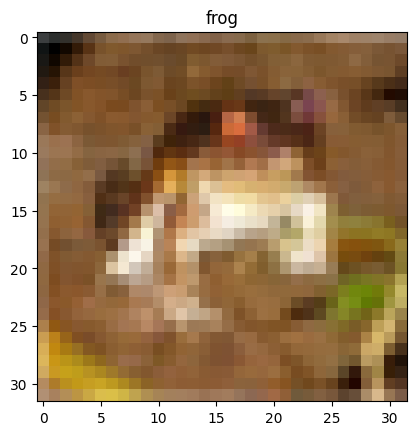

In [8]:
#lets print out an image
print('Image Size: %s' % (str(image.shape)))

image = image.permute(1,2,0) #we need to switch the spot where the color channel is cuz the other libraries put color channel as the 3rd element
plt.imshow(image)
plt.title(class_names[label])


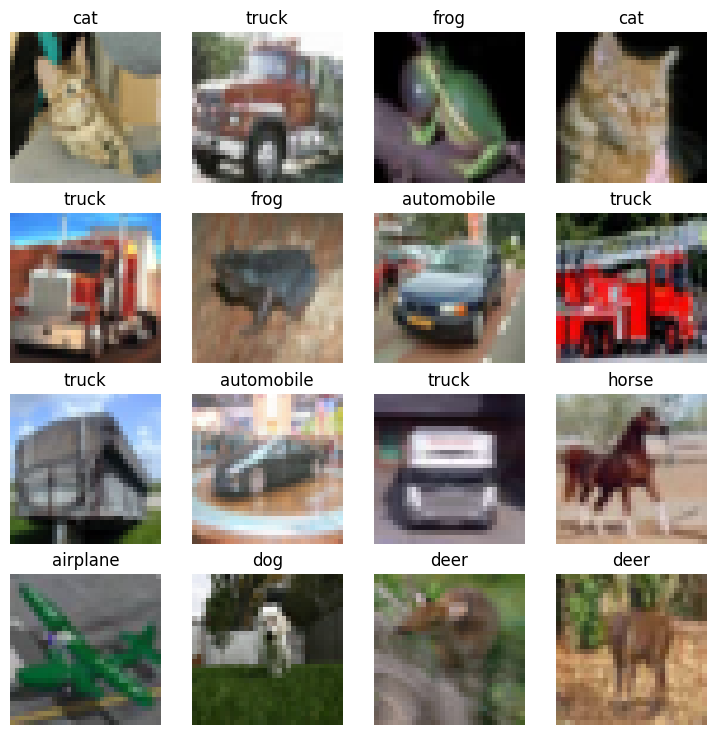

In [9]:
# lets show some more data
torch.manual_seed(17)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range (1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  img = img.permute(1,2,0)
  fig.add_subplot(rows, cols, i)
  plt.imshow(img)
  plt.title(class_names[label])
  plt.axis(False)

## Create the Dataloader

In [42]:
batch_size = 32 #we can play with this number, https://chat.openai.com/c/b2a0fc5d-aba9-4d03-814e-21e279471dbd

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             shuffle=False)

## Train and Test Functions

In [11]:
def train(model:torch.nn.Module,
          data_loader:torch.utils.data.DataLoader,
          criterion:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          accuracy_fn,
          device:torch.device=device):
  train_loss, train_acc = 0, 0
  model.to(device)
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = criterion(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print('Train Loss: %s | Train Accuracy: %s' % (train_loss, train_acc))

In [12]:
def test(model:torch.nn.Module,
         data_loader:torch.utils.data.DataLoader,
         criterion:torch.nn.Module,
         optimizer:torch.optim.Optimizer,
         accuracy_fn,
         device:torch.device=device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = criterion(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(test_pred, y)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print('Test Loss: %s | Test Accuracy: %s' % (test_loss, test_acc))

## Convolutional Neural Network

In [50]:
#this model is based on https://poloclub.github.io/cnn-explainer/
#this website is how we are dictating our hidden layers and number of neruons
class Model(nn.Module):
  def __init__(self, input_shape:int,
               output_shape:int):
    super(Model, self).__init__()

    self.block1 = nn.Sequential(nn.Conv2d(in_channels=input_shape,
                                          out_channels=32,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2,
                                             stride=2))
    self.block2 = nn.Sequential(nn.Conv2d(in_channels=64,
                                          out_channels=64,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64,
                                          out_channels=10,
                                          kernel_size=3,
                                          stride=1,
                                          padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2,
                                             stride=2))
    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=10*8*8,
                                              out_features=output_shape))

  def forward(self, x):
    x = self.block1(x)
    #print(x.shape)
    x = self.block2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

model = Model(input_shape=3,
              output_shape=len(class_names)).to(device)
model

Model(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)

### Figuring out the shape throughout the model

In [14]:
rand_img, rand_label = train_data[0]
rand_img.shape

torch.Size([3, 32, 32])

In [15]:
#we now want to pass a random image through the model
rand_img_tensor = torch.randn(size=(3, 32, 32)).to(device)
rand_img_tensor.shape

torch.Size([3, 32, 32])

In [16]:
#model(rand_img_tensor.unsqueeze(0)).to(device)
#the code above will give us an error to do the classifier step because we have the wrong shape but then we just have to multiply the nn.Linear infeatures to match the
# first matrix using the size we get in the last step. so we can do 10*8*8

## Criterion and Optimizer

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer  = torch.optim.SGD(model.parameters(), lr=1e-2)

## Train and Test the Model

In [18]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [53]:
from tqdm.auto import tqdm
accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

train_time_start = timer()

epochs = 6

for epoch in tqdm(range(epochs)):
  print('Epoch: %s \n-------------' % (epoch))
  train(model, train_dataloader, criterion, optimizer, accuracy_fn, device)

  test(model, test_dataloader, criterion, optimizer, accuracy_fn, device)

train_time_end = timer()
total_train_time = print_train_time(start=train_time_start,
                                    end=train_time_end,
                                    device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0 
-------------
Train Loss: tensor(2.1167, device='cuda:0', grad_fn=<DivBackward0>) | Train Accuracy: tensor(0.2192, device='cuda:0')
Test Loss: tensor(1.9402, device='cuda:0') | Test Accuracy: tensor(0.3160, device='cuda:0')
Epoch: 1 
-------------
Train Loss: tensor(1.8229, device='cuda:0', grad_fn=<DivBackward0>) | Train Accuracy: tensor(0.3540, device='cuda:0')
Test Loss: tensor(1.7145, device='cuda:0') | Test Accuracy: tensor(0.4001, device='cuda:0')
Epoch: 2 
-------------
Train Loss: tensor(1.6274, device='cuda:0', grad_fn=<DivBackward0>) | Train Accuracy: tensor(0.4188, device='cuda:0')
Test Loss: tensor(1.5325, device='cuda:0') | Test Accuracy: tensor(0.4533, device='cuda:0')
Epoch: 3 
-------------
Train Loss: tensor(1.4419, device='cuda:0', grad_fn=<DivBackward0>) | Train Accuracy: tensor(0.4834, device='cuda:0')
Test Loss: tensor(1.3850, device='cuda:0') | Test Accuracy: tensor(0.5114, device='cuda:0')
Epoch: 4 
-------------
Train Loss: tensor(1.3320, device='cuda: